In [1]:
import pickle as pkl

import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

pd.set_option('display.max_columns', 500)

%matplotlib inline

 #### Reading preprocessed data

In [2]:
course_details = pd.read_pickle('Data/Preproccessed Data/course_details.pkl')

In [3]:
course_syllabi = pd.read_pickle('Data/Preproccessed Data/course_syllabi.pkl')

In [4]:
course_reviews = pd.read_pickle('Data/Preproccessed Data/course_reviews.pkl')

### Difference in  means between paid and free courses :

- investigating the difference in success between paid and free course :


(only 384/9718, ~4% are free, we should have different criterions of success for paid and free courses )

In [5]:
course_details['is_paid'].value_counts()

True     9333
False     384
Name: is_paid, dtype: int64

We add histogram and boxplot to inspect for tail, maybe there is ONE course that has a lot more subscirbers than the group.

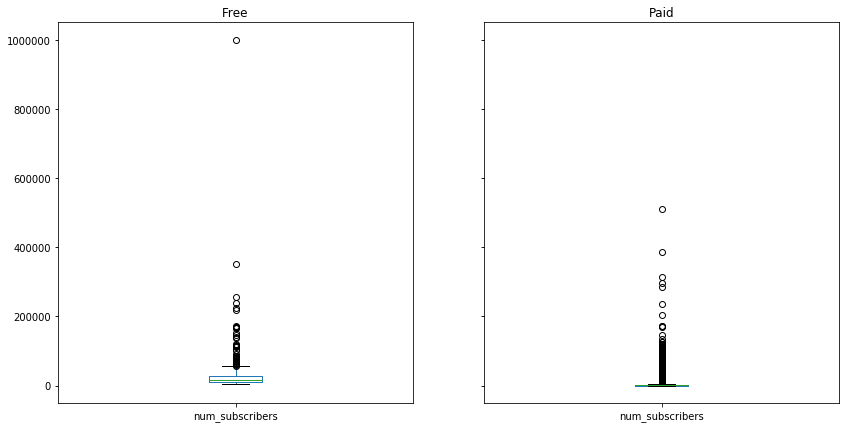

In [6]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,7))

# set title
ax[0].set_title('Free')
ax[1].set_title('Paid')


#plot

free = course_details[~course_details['is_paid']].sort_values('num_subscribers',ascending=False)
paid = course_details[ course_details['is_paid']].sort_values('num_subscribers',ascending=False)

free['num_subscribers'].plot.box(ax=ax[0])
paid['num_subscribers'].plot.box(ax=ax[1])

We observe that both distributions of number ofsubscribers for free and paid courses are very skewed. We drop one outlier from free and 2 ouliters from paid

In [7]:
#  outliers : one for free courses, 2 for paid courses
outliers_id = pd.concat([free.iloc[[0],:], paid.iloc[:2,:]]).index.tolist()

In [8]:
# we dont drop the outliers
#course_details.drop(outliers_id,inplace=True)

In [9]:
all_courses  = course_details.mean().rename('All courses')
paid_courses = course_details[course_details['is_paid']].mean().rename('Paid courses')
free_courses = course_details[~course_details['is_paid']].mean().rename('Free courses')

pd.concat([free_courses, paid_courses,all_courses], axis=1)

,Free courses,Paid courses,All courses
avg_rating,4.192206,3.658196,3.679299
avg_rating_recent,4.210535,3.656025,3.677938
is_paid,0.000000,1.000000,0.960482
num_published_lectures,30.984375,52.843459,51.979623
num_published_practice_tests,0.000000,0.012536,0.012041
num_published_quizzes,1.002604,1.242044,1.232582
num_reviews,1535.666667,305.072538,353.703612
num_reviews_recent,163.828125,46.936462,51.555830
num_subscribers,32066.526042,3584.828565,4710.378821
content_length,3.449826,6.269931,6.158485


First, we see the predominance of the paid courses as they represent 96% of this dataset. With this big proportion being paid, we can see the means of the paid group are very close to the means of the full dataset.

We observe that for success factors, free courses are dominating : in terms of total subrscibers, the free courses hit 9 times more subscriber and 5 times more reviews than the paid ones on average.

Conversely, free courses also seems to be less diligent in their content : the content length is doubled for paid courses, with 6h15 of lectures on averages for paid courses against 3h30 for free courses. The number of lectures is also higher for paid courses (+70%) .



In [10]:
# storing free courses before drop
course_details_free = course_details[~course_details['is_paid']]

In [11]:
# dropping free courses and is_paid column

course_details = course_details[course_details['is_paid']]
course_details.drop('is_paid', axis=1, inplace=True)

# ** Now we only work with paid courses **

### 1. Ranking the courses

In this section,  we try to rank the courses using meaningfull scales.

###### Rank1

In [12]:
# rank by ratings
course_details['Rank1 by avg_rating'] = course_details['avg_rating'].rank(method='min',ascending=False)

#### Rank2

In [13]:
# rank by num subscribers
course_details['Rank2 by num_subs'] = course_details['num_subscribers'].rank(method='min',ascending=False)

#### Rank 3 and 4

In [14]:
# Creating the column 'age in months'

# change today to when the dataset was scrapped : it was february 2019
course_details['age in days'] = (datetime(2019,2,28) - course_details['published_time']).apply(lambda x : ((x.days)/30)+1)

In [15]:
course_details['avg_r/(age)'] = course_details.apply(lambda row : row['avg_rating']/(row['age in days']), axis=1)

course_details['Rank3 by avg_r/(age)'] = course_details['avg_r/(age)'].rank(method='min', ascending=False)

In [16]:
course_details['n_subs/(age)'] = course_details.apply(lambda row : row['num_subscribers']/(row['age in days']), axis=1)

course_details['Rank4 by n_subs/(age)'] = course_details['n_subs/(age)'].rank(method='min',ascending=False)

#### Rank 5 and 6

In [17]:
c1 = 2 #0.0025
c2 = 5 #0.02

In [18]:
# rank by average rating divided by ln(course age in days)
course_details['avg_r/ln(age)'] = course_details.apply(lambda row : row['avg_rating']/np.log(c1*row['age in days']), axis=1)

In [19]:
course_details['Rank5 by avg_r/ln(age)'] = course_details['avg_r/ln(age)'].rank(method='min',ascending=False)

#course_details.drop('avg_r/ln(age)',axis=1,inplace=True)

course_details['n_subs/ln(age)'] = course_details.apply(lambda row : row['num_subscribers']/np.log(c2*row['age in days']), axis=1)

course_details['Rank6 by n_subs/ln(age)'] = course_details['n_subs/ln(age)'].rank(method='min',ascending=False)

#course_details.drop('n_subs/ln(age)',axis=1,inplace=True)


#### Comparing the ranks

**One way to combine the 4 rankings, is to minimize the distance to all 4 ranks :  ==> By Mean of rankings**

We want our output rank to be such that each course rank is at minimal total distance of its input ranks, in this case they are 4, and to be a valid rank


In [20]:
course_details

,avg_rating,avg_rating_recent,created,last_update_date,num_published_lectures,num_published_practice_tests,num_published_quizzes,num_reviews,num_reviews_recent,num_subscribers,objectives,prerequisites,price,published_time,rating_distribution,target_audiences,title,url,content_length,publication_gap,Rank1 by avg_rating,Rank2 by num_subs,age in days,avg_r/(age),Rank3 by avg_r/(age),n_subs/(age),Rank4 by n_subs/(age),avg_r/ln(age),Rank5 by avg_r/ln(age),n_subs/ln(age),Rank6 by n_subs/ln(age)
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8082,4.38095,4.34115,2011-06-14 16:09:14,2015-10-15,56,0,5,620,18,28367,[Hours of video lectures detailing the ten ste...,[],$74.99,2011-07-08 21:32:55,"[{'count': 6, 'rating': 1}, {'count': 19, 'rat...",[],Ruby Programming for Beginners,/learn-ruby-programming-in-ten-easy-steps/,6.000000,0.066369,2554.0,203.0,94.033333,0.046589,8406.0,301.669621,1247.0,0.836571,7294.0,4610.206045,282.0
8203,3.45000,3.73183,2011-06-20 19:59:32,2017-07-10,15,0,1,12,10,1550,"[In this course, you will learn how to build a...",[PC or MAC with a browser installed],$99.99,2011-06-20 17:48:46,"[{'rating': 1, 'count': 2}, {'rating': 2, 'cou...",[This course is intended for those who have ba...,Basic and Advanced HTML Lessons,/learn-html-in-24-hours/,1.000000,-0.000249,7245.0,3124.0,94.633333,0.036456,8464.0,16.379007,5274.0,0.658001,8186.0,251.645939,3597.0
8319,3.60000,3.79901,2011-06-28 04:48:38,NaT,31,0,0,12,10,290,"[The normal Git workflow, How to collaborate w...",[],$19.99,2011-07-29 20:24:56,"[{'rating': 1, 'count': 2}, {'rating': 2, 'cou...",[],Git Basics: In Theory and Practice,/git-in-theory-and-in-practice/,7.500000,0.086713,6814.0,5516.0,93.333333,0.038571,8457.0,3.107143,7371.0,0.688425,8116.0,47.188115,5878.0
8324,3.95000,3.90651,2011-06-28 08:26:18,2018-07-06,48,0,6,243,10,3799,"[Extensive, informative and interesting video ...",[Some basic knowledge of HTML is required for ...,$19.99,2011-07-09 05:43:31,"[{'rating': 1, 'count': 8}, {'rating': 2, 'cou...",[Web Designers looking to improve their skill ...,Javascript for Beginners,/beginning-javascript/,3.000000,0.029827,5434.0,1719.0,94.000000,0.042021,8438.0,40.414894,4009.0,0.754329,7878.0,617.449219,2169.0
8325,4.65000,4.57516,2011-06-28 08:27:39,2018-07-06,82,0,5,284,10,12508,"[The HTML Document Structure For HTML 4.01, XH...","[PC, Mac or Linux PC, Text Editor (Free!), Web...",$19.99,2011-09-09 15:28:59,"[{'count': 5, 'rating': 1}, {'count': 8, 'rati...",[People who want to better manage their web si...,HTML Tutorial: HTML & CSS for Beginners,/learn-html5/,4.000000,0.200802,822.0,541.0,91.933333,0.050580,8348.0,136.055112,2212.0,0.891794,6651.0,2040.289823,775.0
8416,3.85000,3.98956,2011-07-05 19:40:19,2017-01-09,81,0,0,21,10,2039,[Everything you need to develop iOS apps for t...,[A system running Mac OSX is required to devel...,$49.99,2011-07-06 23:45:18,"[{'rating': 1, 'count': 4}, {'rating': 2, 'cou...",[Anyone who wants to learn how to build an iPh...,Beginners - How To Create iPhone And iPad Apps...,/beginners-guide-to-iphone-ipad-app-creation/,7.500000,0.003206,5893.0,2661.0,94.100000,0.040914,8446.0,21.668438,4905.0,0.735083,7951.0,331.340203,3110.0
8723,4.05000,4.15694,2011-07-25 05:16:32,2018-07-06,71,0,0,80,10,2018,[How to use Apples XCode Development Environme...,[],$19.99,2011-10-25 19:53:45,"[{'count': 4, 'rating': 1}, {'count': 3, 'rati...",[People without programming experience who wan...,C Programming: iOS Development Starts Here!,/c-programming-ios-development-starts-here/,4.000000,0.253724,4801.0,2684.0,90.400000,0.044801,8419.0,22.323009,4858.0,0.779237,7745.0,330.079311,3121.0
9463,4.22727,4.21872,2011-09-03 02:16:27,2017-01-09,114,0,0,1066,45,54180,[Learn Java Programming from a professional tr...,[],$49.99,2011-09-15 15:19:57,"[{'rating': 1, 'count': 34}, {'rating': 2, 'co...",[],Programming Java for Beginners - The Ultimate ...,/learn-to-program-with-java/,10.000000,0.034367,3695.0,85.0,91.733333,0.046082,8409.0,590.625000,687.0,0.811060,7509

In [21]:
agg_rank = (course_details['Rank3 by avg_r/(age)']+
             course_details['Rank5 by avg_r/ln(age)']+
             course_details['Rank1 by avg_rating']+
             course_details['Rank4 by n_subs/(age)']+
             course_details['Rank6 by n_subs/ln(age)']+
             course_details['Rank2 by num_subs'])/6

course_details['Rank aggreg']= agg_rank.rank(method='min',ascending=True)

Correlation:

In [22]:
ranks_Df = course_details[['Rank3 by avg_r/(age)',
                           'Rank4 by n_subs/(age)',
                           'Rank1 by avg_rating',
                           'Rank2 by num_subs',
                           'Rank5 by avg_r/ln(age)',
                           'Rank6 by n_subs/ln(age)',
                           'Rank aggreg']]
corr = ranks_Df.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,Rank3 by avg_r/(age),Rank4 by n_subs/(age),Rank1 by avg_rating,Rank2 by num_subs,Rank5 by avg_r/ln(age),Rank6 by n_subs/ln(age),Rank aggreg
Rank3 by avg_r/(age),1,0.330092,0.472715,0.0791468,0.937804,0.137937,0.619897
Rank4 by n_subs/(age),0.330092,1,0.348233,0.937995,0.382194,0.963173,0.883665
Rank1 by avg_rating,0.472715,0.348233,1,0.316874,0.697052,0.326466,0.666868
Rank2 by num_subs,0.0791468,0.937995,0.316874,1,0.166505,0.996393,0.76315
Rank5 by avg_r/ln(age),0.937804,0.382194,0.697052,0.166505,1,0.218403,0.723729
Rank6 by n_subs/ln(age),0.137937,0.963173,0.326466,0.996393,0.218403,1,0.799338
Rank aggreg,0.619897,0.883665,0.666868,0.76315,0.723729,0.799338,1


**==>**  Finally, we will only keep the Rank4 (**n_subs/age**), as it is the most correlated one with the aggregated rank.

In [23]:
course_details.drop(['Rank1 by avg_rating',
                     'Rank2 by num_subs',
                     'avg_r/(age)',
                     'Rank3 by avg_r/(age)',
                     'avg_r/ln(age)',
                     'Rank5 by avg_r/ln(age)',
                     'n_subs/ln(age)',
                     'Rank6 by n_subs/ln(age)'], axis=1, inplace=True)

We now plot the distribution of **n_subs/age** over the dataset.

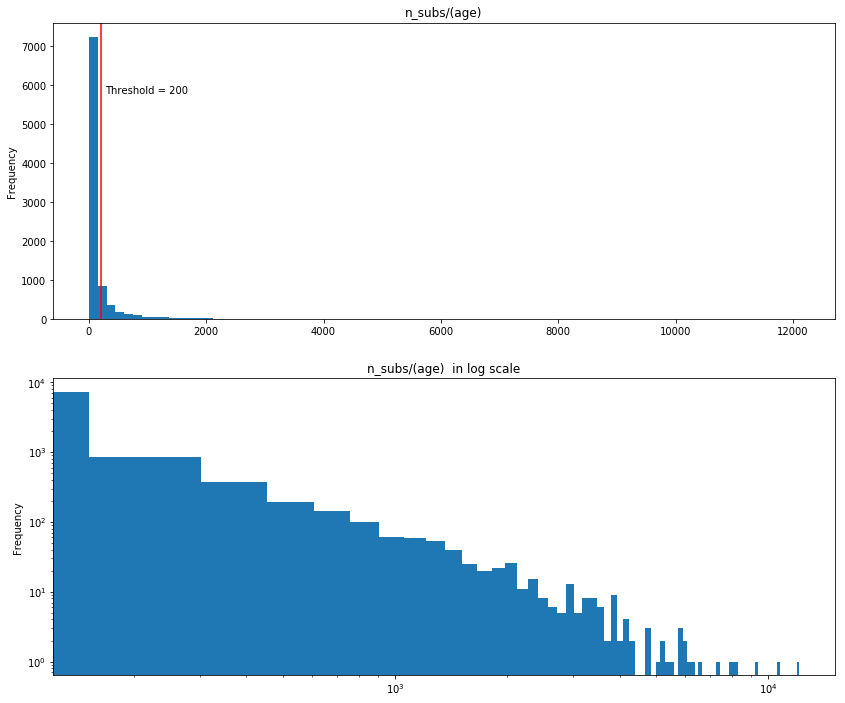

In [24]:
fig, ax= plt.subplots(2,1,figsize=(14,12))

course_details['n_subs/(age)'].sort_values().plot.hist(bins=80, title='n_subs/(age)',ax=ax[0])
ax[0].axvline(200, color='r')
ax[0].text(0.12, 0.77, 'Threshold = 200', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)

course_details['n_subs/(age)'].sort_values().plot.hist(bins=80, title='n_subs/(age)  in log scale',ax=ax[1])

plt.yscale('log')
plt.xscale('log')

In [25]:
# models to predict succesfulness, then we do the harmonic mean of accuray and prctge of data used, then pick best

In [26]:
ser = course_details['n_subs/(age)'].apply(lambda x : x>200) # how to choose this threshold
ser.mean()

0.18450658952105434

We have 18.5% of the courses that score higher than 200 at this metric ( **n_subs/(age)** ). 
We **label them as successfull** and we now have our **dependant variable**

In [27]:
course_details['success'] = ser

### We have now "defined" a successful course set from our dataset.

**What are the biggest courses in term of number of elements ?** here we consider an element any content present in course_syllabi and affiliated to a course via course_id column.

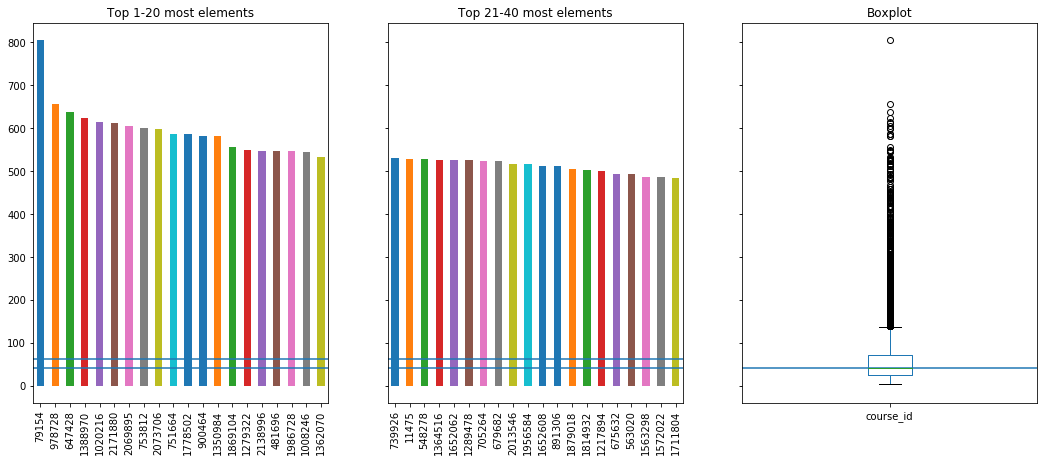

In [28]:
fig, ax = plt.subplots(1,3, sharey=True)

course_syllabi['course_id'].value_counts().head(20).plot(ax=ax[0], kind='bar', figsize=(18,7))

ax[0].axhline(course_syllabi['course_id'].value_counts().mean())
ax[0].axhline(course_syllabi['course_id'].value_counts().median())
ax[0].set_title('Top 1-20 most elements')

course_syllabi['course_id'].value_counts().head(40).tail(20).tail(20).plot(ax=ax[1], kind='bar', figsize=(18,7))

ax[1].axhline(course_syllabi['course_id'].value_counts().mean())
ax[1].axhline(course_syllabi['course_id'].value_counts().median())
ax[1].set_title('Top 21-40 most elements')

course_syllabi['course_id'].value_counts().plot.box(ax=ax[2])
ax[2].set_title('Boxplot')
ax[2].axhline(course_syllabi['course_id'].value_counts().median())

We can see there is a large gap between the top representives and the rest.

In [29]:
course_details['nbr of course element'] = course_syllabi['course_id'].value_counts()

### **How are courses updated?** Each course has a dataframe of various updates, we are gonna investigate it here 

In [30]:
course_syllabi.head(3)

,course_id,chapter_title,chapter_description,chapter_created,content_class,title,description,created_content,is_published,content_summary,url,age_from_creation,age_from_publication
0,8082,NaN,NaN,NaT,course,Ruby Programming for Beginners,NaN,2011-06-14 16:09:14,NaN,NaN,/learn-ruby-programming-in-ten-easy-steps/,0.000000,-0.066369
1,8082,NaN,NaN,NaT,chapter,Introduction,NaN,2011-06-17 21:36:49,True,NaN,NaN,0.008842,-0.057527
2,8082,Introduction,NaN,2011-06-17 21:36:49,lecture,Ruby Programming for Beginners - Intro,NaN,2012-02-17 17:57:19,True,01:55,/learn-ruby-programming-in-ten-easy-steps/lear...,0.679658,0.613288


In [31]:
time_serie = course_syllabi[['course_id','created_content']].groupby('course_id')['created_content'].apply(list)

In [32]:
a = time_serie.index.tolist()
b = course_details.index.tolist()

# some courses in syllabi are not in details : might be free courses
not_in_details = (set(a)-set(b))

In [33]:
free = set(course_details_free.index.tolist())

In [34]:
# all free courses are in the missing set
free-not_in_details

set()

In [35]:
# this last course was removed during preprocessing as an outlier
not_in_details -free  

{1965490}

**Average update delay**

In [36]:
# function to be used in calculating time interval between consecutive updates in next cell

def diff(lst):
    # should handle empty and one elem lists

    res =[] 
    for i in range(len(lst)-1):
        res.append(lst[i+1]-lst[i])
    
    if res == []: res = [timedelta(0)]
    return res

In [37]:
# creating the new columns and sorting its content
course_details['update_date_list'] = time_serie.apply(lambda x : sorted(x) )

# removing dates that are prior to publication date of the course, 
# ie these updates were not visible and were already made the first time the course was published
course_details['update_date_list'] = course_details.apply(lambda row : [elem for elem in row['update_date_list'] if elem < row['published_time']], axis =1)

In [38]:
# getting differences between consecutive uploads
course_details['update_delta_list'] = course_details['update_date_list'].apply(diff)

# turning timedelta to seconds
course_details['update_delta_list'] = course_details['update_delta_list'].apply(lambda x : [elem.total_seconds() for elem in x])

# retrieving nans
course_details['update_delta_list'] = course_details['update_delta_list'].apply(lambda x : [elem for elem in x if np.isnan(elem)==False])

In [39]:
# Now we plot the various time delta of the dataset, and decide a threshold for bulk loading, ie, for a threshold of 1 day,
# contents uploaded whithin 24 hour of each other are counted as the same update

list_of_lists = course_details['update_delta_list'].values.tolist()
# flatening the list
flat_list = [elem for sublist in list_of_lists for elem in sublist]


to_plot = pd.Series(flat_list)

In [40]:
#sns.distplot(to_plot, hist=True, kde=False, bins=int(180/5), color = 'blue', hist_kws={'edgecolor':'black'})

In [41]:
threshold = 60*60*3 # 3hours

In [42]:
# remving time_deltas that are less than our threshold
course_details['update_delta_list'] = course_details['update_delta_list'].apply(lambda x : [elem for elem in x if (elem>threshold)])

In [43]:
# mean time of update
course_details['Avg update delay'] = course_details['update_delta_list'].apply(lambda x : np.mean(x) if len(x) >0 else 0 )
course_details['Avg update delay (days)'] = course_details['Avg update delay'].apply(lambda x : x/(60*60*24))

**Type of updated content**

The column ***content_summary*** contain informations under various formats, which are :
- NumberOfPages
- DurationoÔfLecture
- FileSize

In [44]:
course_syllabi['content_summary'] = course_syllabi['content_summary'].fillna('')

course_syllabi['content is in pages'] = course_syllabi['content_summary'].apply(lambda x : 'page' in x)
course_syllabi['content is in time'] = course_syllabi['content_summary'].apply(lambda x : ':' in x)
course_syllabi['content is in bytes'] = course_syllabi['content_summary'].apply(lambda x : 'B' in x)
course_syllabi['content is na'] = course_syllabi['content_summary'].apply(lambda x : x=='')

In [45]:
# verifying we did not omit any information format

course_syllabi['at least one'] = course_syllabi['content is in pages'] |course_syllabi['content is in time']|course_syllabi['content is in bytes']|course_syllabi['content is na']
course_syllabi['exactly one'] = course_syllabi['content is in pages'] ^ course_syllabi['content is in time']^course_syllabi['content is in bytes']^course_syllabi['content is na']

In [46]:
course_syllabi[course_syllabi['at least one']==False]['content_summary'].value_counts()

Processing..    194
IFrame            3
Name: content_summary, dtype: int64

In [47]:
course_syllabi[course_syllabi['exactly one']==False]['content_summary'].value_counts()

Processing..    194
IFrame            3
Name: content_summary, dtype: int64

** What are processing and IFrame** all our data points are from exactly one of the three types of content, but 2 more content_type are unknown : 'Processing' and 'IFrame', these content will not be counted as some size of updates.  **==> We turn these  values to nan.
**

In [48]:
# We treat them as nans
course_syllabi['content_summary'].fillna('Processing..', inplace=True)
course_syllabi['content_summary'].fillna('IFrame', inplace=True)

**Size of updates**

We have 3 types of content : Number of pages, time, and filesize (in Bytes).

In [49]:
# do operation for each in syllabi, then sum in details
course_syllabi['size_in_pages']= course_syllabi[course_syllabi['content is in pages']]['content_summary'].\
                                    apply(lambda st : sum([int(s) for s in st.split() if s.isdigit() ]))


course_details['size_in_pages'] = course_syllabi[course_syllabi['content is in pages']][['course_id','size_in_pages']].\
                                    groupby('course_id')['size_in_pages'].\
                                    apply(sum)

In [50]:
course_syllabi['size_in_seconds'] = course_syllabi[course_syllabi['content is in time']]['content_summary'].\
                                    apply(lambda elem :  [int(i) for i in elem.split(':')]).\
                                    apply(lambda x : x[0]*60+x[1])

course_details['size_in_seconds'] = course_syllabi[course_syllabi['content is in time']][['course_id','size_in_seconds']].\
                                    groupby('course_id')['size_in_seconds'].\
                                    apply(sum)

In [51]:
course_syllabi['size_in_bytes'] = course_syllabi[course_syllabi['content is in bytes']]['content_summary'].\
                                    apply(lambda elem :  elem.split(' ')).\
                                    apply(lambda couple : float(couple[0]) if couple[1] =='Bytes' else \
                                                      (float(couple[0])*10**3 if couple[1]=='kB' else\
                                                       (float(couple[0])*10**6 if couple[1]=='MB' else\
                                                        couple)))

course_details['size_in_bytes'] = course_syllabi[course_syllabi['content is in bytes']][['course_id','size_in_bytes']].\
                                    groupby('course_id')['size_in_bytes'].\
                                    apply(sum)

**NA count**

In [52]:
course_details[['size_in_pages','size_in_bytes', 'size_in_seconds']].isna().sum()

size_in_pages      8762
size_in_bytes      9292
size_in_seconds       0
dtype: int64

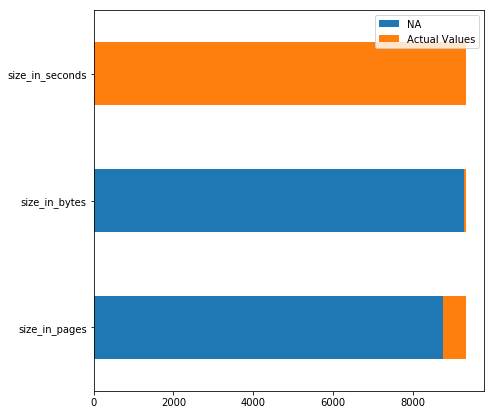

In [53]:
df = pd.concat([course_details[['size_in_pages','size_in_bytes', 'size_in_seconds']].isna().sum(), course_details.shape[0]-course_details[['size_in_pages','size_in_bytes', 'size_in_seconds']].isna().sum()], axis=1)
df.rename(columns={0:'NA', 1:'Actual Values'},inplace=True)
df.plot.barh(stacked=True, figsize=(7,7))

As size in bytes and in pages is absent for a significant portion of courses in the dataset, we will only consider size in seconds.

In [54]:
course_syllabi.drop(['size_in_pages', 'size_in_bytes'], axis=1, inplace=True)
course_details.drop(['size_in_pages', 'size_in_bytes'], axis=1, inplace=True)

** Average size of updates**

In [55]:
course_details

,avg_rating,avg_rating_recent,created,last_update_date,num_published_lectures,num_published_practice_tests,num_published_quizzes,num_reviews,num_reviews_recent,num_subscribers,objectives,prerequisites,price,published_time,rating_distribution,target_audiences,title,url,content_length,publication_gap,age in days,n_subs/(age),Rank4 by n_subs/(age),Rank aggreg,success,nbr of course element,update_date_list,update_delta_list,Avg update delay,Avg update delay (days),size_in_seconds
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8082,4.38095,4.34115,2011-06-14 16:09:14,2015-10-15,56,0,5,620,18,28367,[Hours of video lectures detailing the ten ste...,[],$74.99,2011-07-08 21:32:55,"[{'count': 6, 'rating': 1}, {'count': 19, 'rat...",[],Ruby Programming for Beginners,/learn-ruby-programming-in-ten-easy-steps/,6.000000,0.066369,94.033333,301.669621,1247.0,2657.0,True,75,"[2011-06-14 16:09:14, 2011-06-15 18:01:06, 201...","[93112.0, 98832.0, 12570.0, 62973.0, 252178.0,...",1.297656e+05,1.501916,13465.0
8203,3.45000,3.73183,2011-06-20 19:59:32,2017-07-10,15,0,1,12,10,1550,"[In this course, you will learn how to build a...",[PC or MAC with a browser installed],$99.99,2011-06-20 17:48:46,"[{'rating': 1, 'count': 2}, {'rating': 2, 'cou...",[This course is intended for those who have ba...,Basic and Advanced HTML Lessons,/learn-html-in-24-hours/,1.000000,-0.000249,94.633333,16.379007,5274.0,7068.0,False,20,[],[],0.000000e+00,0.000000,2438.0
8319,3.60000,3.79901,2011-06-28 04:48:38,NaT,31,0,0,12,10,290,"[The normal Git workflow, How to collaborate w...",[],$19.99,2011-07-29 20:24:56,"[{'rating': 1, 'count': 2}, {'rating': 2, 'cou...",[],Git Basics: In Theory and Practice,/git-in-theory-and-in-practice/,7.500000,0.086713,93.333333,3.107143,7371.0,8060.0,False,36,"[2011-06-28 04:48:38, 2011-06-28 04:51:27, 201...","[21378.0, 31035.0, 91462.0, 1635165.0, 99133.0...",2.741634e+05,3.173188,10423.0
8324,3.95000,3.90651,2011-06-28 08:26:18,2018-07-06,48,0,6,243,10,3799,"[Extensive, informative and interesting video ...",[Some basic knowledge of HTML is required for ...,$19.99,2011-07-09 05:43:31,"[{'rating': 1, 'count': 8}, {'rating': 2, 'cou...",[Web Designers looking to improve their skill ...,Javascript for Beginners,/beginning-javascript/,3.000000,0.029827,94.000000,40.414894,4009.0,5551.0,False,67,"[2011-06-28 08:26:18, 2011-07-02 06:06:23, 201...","[337205.0, 133874.0, 11666.0, 46113.0, 42550.0...",1.132569e+05,1.310843,9399.0
8325,4.65000,4.57516,2011-06-28 08:27:39,2018-07-06,82,0,5,284,10,12508,"[The HTML Document Structure For HTML 4.01, XH...","[PC, Mac or Linux PC, Text Editor (Free!), Web...",$19.99,2011-09-09 15:28:59,"[{'count': 5, 'rating': 1}, {'count': 8, 'rati...",[People who want to better manage their web si...,HTML Tutorial: HTML & CSS for Beginners,/learn-html5/,4.000000,0.200802,91.933333,136.055112,2212.0,2483.0,False,99,"[2011-06-28 08:27:39, 2011-08-05 23:37:27, 201...","[3337788.0, 171769.0, 639755.0, 1867545.0, 129...",1.229227e+06,14.227160,14225.0
8416,3.85000,3.98956,2011-07-05 19:40:19,2017-01-09,81,0,0,21,10,2039,[Everything you need to develop iOS apps for t...,[A system running Mac OSX is required to devel...,$49.99,2011-07-06 23:45:18,"[{'rating': 1, 'count': 4}, {'rating': 2, 'cou...",[Anyone who wants to learn how to build an iPh...,Beginners - How To Create iPhone And iPad Apps...,/beginners-guide-to-iphone-ipad-app-creation/,7.500000,0.003206,94.100000,21.668438,4905.0,6398.0,False,96,[2011-07-05 19:40:19],[],0.000000e+00,0.000000,27537.0
8723,4.05000,4.15694,2011-07-25 05:16:32,2018-07-06,71,0,0,80,10,2018,[How to use Apples XCode Development Environme...,[],$19.99,2011-10-25 19:53:45,"[{'count': 4, 'rating': 1}, {'count': 3, 'rati...",[People without programming experience who wan...,C Programming: iOS Development Starts Here!,/c-programming-ios-development-starts-here/,4.000000,0.253724,90.400000,22.323009,4858.0,6059.0,False,83,"[2011-07-25 05:16:32, 2011-09-22 18:07:17, 201...","[5143845.0, 99633.0, 420575.0, 93329.0, 33

In [56]:
course_details['Average Size of Update'] = course_details['size_in_seconds']/course_details['nbr of course element']

###### Write to ExloredData folder


In [57]:
course_details.to_pickle('Data/Explored Data/course_details.pkl')

In [58]:
course_syllabi.to_pickle('Data/Explored Data/course_syllabi.pkl')

In [59]:
course_reviews.to_pickle('Data/Explored Data/course_reviews.pkl')